In [1]:
import os
import sys

In [2]:
sys.path.append('../lib')

In [3]:
import gen_processes;
import ast

In [4]:
from importlib import reload
reload(gen_processes);

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_default_dtype(torch.double)

In [6]:
from tqdm import tqdm

In [7]:
from itertools import product

In [8]:
import matplotlib.pyplot as plt

In [9]:
import esig

In [10]:
esig.set_backend("iisignature")

In [21]:
from esig import tosig
from scipy.optimize import brentq

In [109]:
def get_keys(dim, order):
    s = tosig.sigkeys(dim, order)

    tuples = []

    for t in s.split():
        if len(t) > 2:
            t = t.replace(")", ",)")

        tuples.append(ast.literal_eval(t))

    return tuples

def f(z, a):
    lol = [z ** (2 * m) for m in range(len(a))]
    out = np.dot(a, lol)
    return out

def phi(x, order):
    x = np.array(x)

    a = x ** 2
    a[0] -= psi(norm(x))

    return brentq(lambda z: f(z, a), 0, 1.001)

def psi(x, M=4, a=1):
    x = x ** 2

    if x <= M:
        return x

    return M + M ** (1 + a) * (M ** (-a) - x ** (-a)) / a

def norm(x):
    return np.linalg.norm(x)

def normalize_sig(sig, order, cheatnum = None):
    keys = get_keys(2, order)

    if cheatnum is None:
        phi_x = phi(tuple(sig), order)
    else:
        phi_x = cheatnum    

    Lambda = np.array([phi_x ** len(t) for t in keys])
    
    return Lambda * sig

def get_normalize_sig_const(sig, order):
    phi_x = phi(tuple(sig), order)
    return phi_x

def get_normalized_gram_matrix_for_paths(paths, order):
    n = paths.shape[0]
    gram = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            sig_i = normalize_sig(esig.stream2sig(paths[i, :, :].reshape(30, 2), order), order)
            sig_j = normalize_sig(esig.stream2sig(paths[j, :, :].reshape(30, 2), order), order)
            gram[i, j] = sig_i @ sig_j.T
    
    return gram

In [93]:
RNG = np.random.default_rng(1234)

In [94]:
processes = gen_processes.gen_ar_iid_samples_burn_in(31, 20, 0, rng = RNG).numpy()
# Indices: Sample, Time, Lead/Lag
processes_ll = np.dstack((processes[:, 1:, 0], processes[:, :30, 0]))
processes_ll = processes_ll/4

In [95]:
def get_lead_lag_proc_length(proc):
    return np.sqrt(np.diff(proc[0])**2 + np.diff(proc[1])**2).sum()

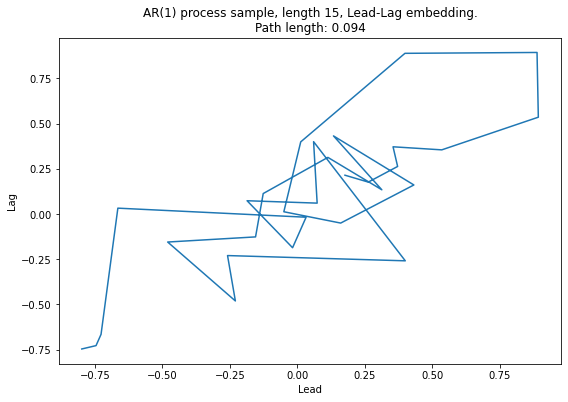

In [96]:
plt.figure(figsize=(9,6))
plt.plot(processes_ll[0, :, 0].reshape(30), processes_ll[0, :,1].reshape(30))
plt.xlabel('Lead')
plt.ylabel('Lag')
plt.title("AR(1) process sample, length 15, Lead-Lag embedding.\nPath length: {:.3f}".format(get_lead_lag_proc_length(processes_ll[0, :].reshape(30, -1))))
plt.savefig('./pics/sig_mistery_ar1_ll_embedding.png')

## Unnormalized signatures and their normalizing constants

In [117]:
get_lead_lag_proc_length(processes_ll[0, :, :])

0.09446812826814911

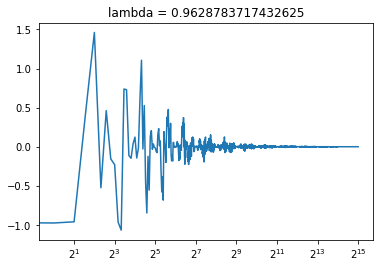

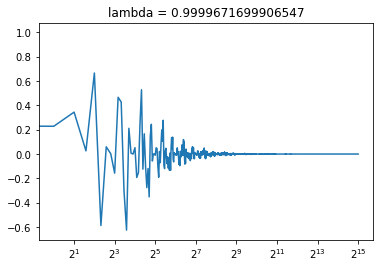

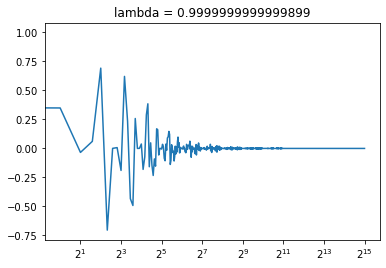

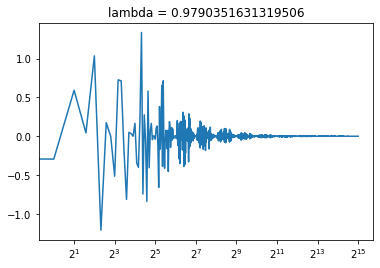

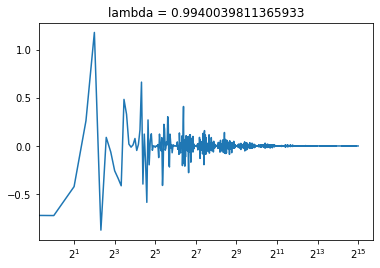

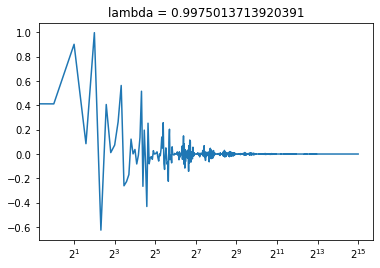

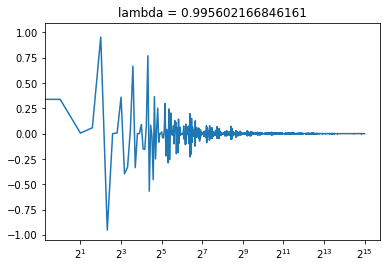

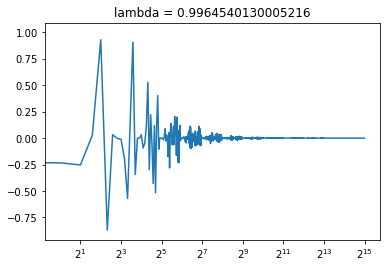

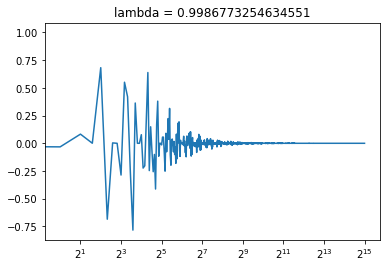

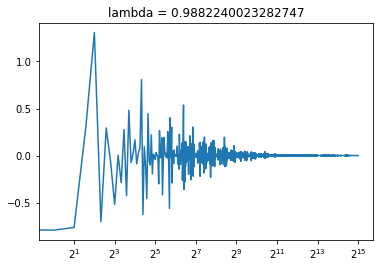

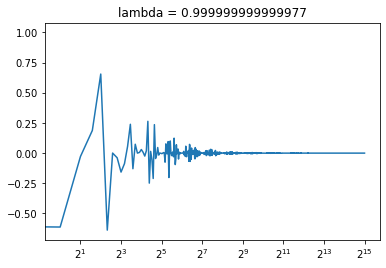

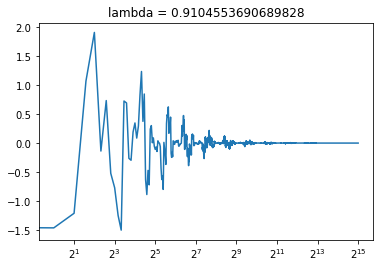

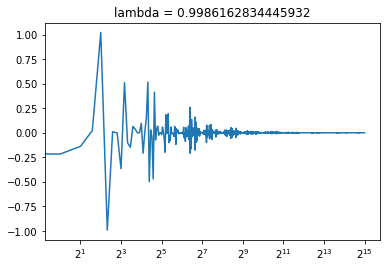

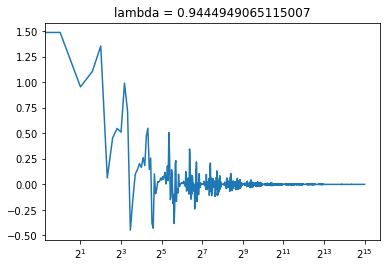

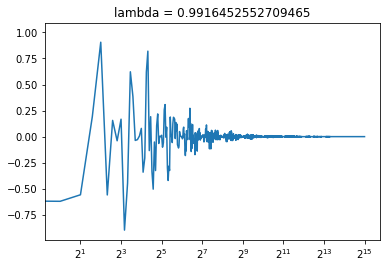

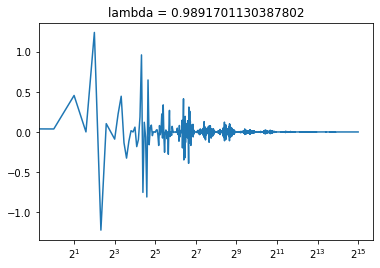

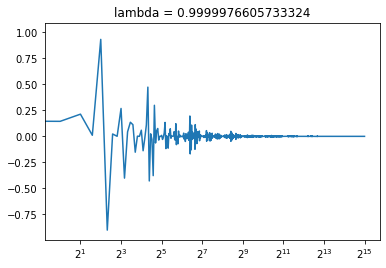

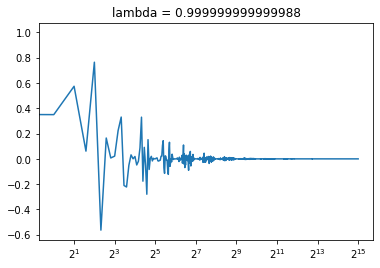

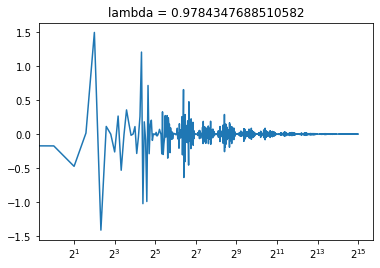

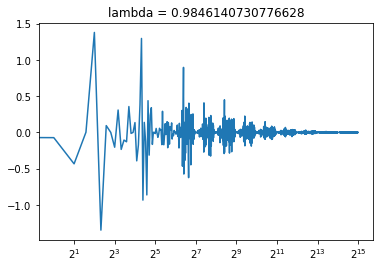

In [97]:
for sample in range(20):
    plt.figure()
    sig_s = esig.stream2sig(processes_ll[sample, :, :].reshape(30, 2), 14)
    lamb = get_normalize_sig_const(sig_s, 14)
    plt.title('lambda = {}'.format(lamb))
    plt.plot(sig_s)
    plt.xscale('log', base = 2)

## Normalized sig vs. unnormalized and scaled - CONFIRMED

0.9628783717432625


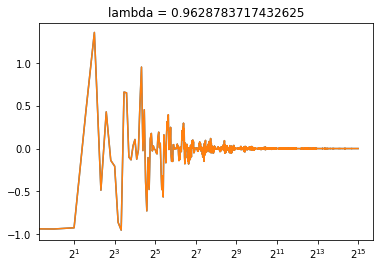

0.9999671699906547


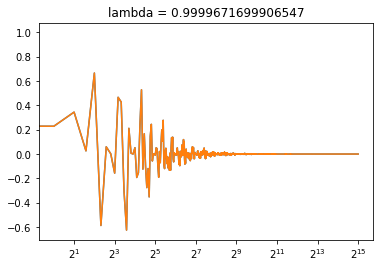

0.9999999999999899


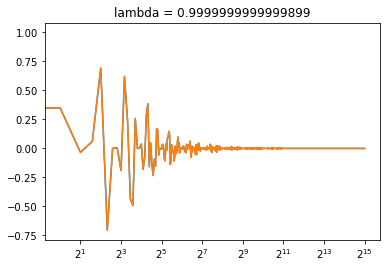

0.9790351631319506


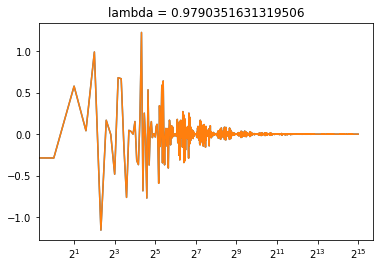

0.9940039811365933


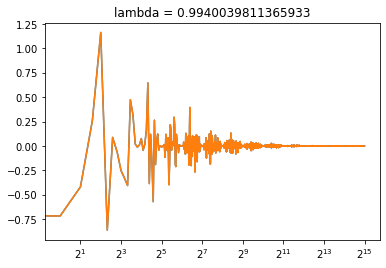

0.9975013713920391


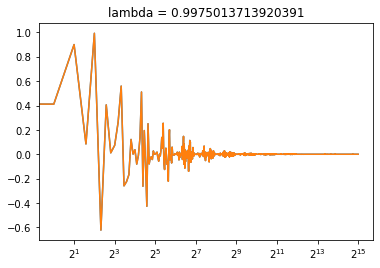

0.995602166846161


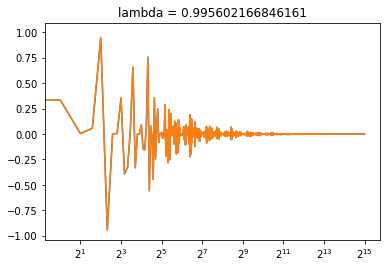

0.9964540130005216


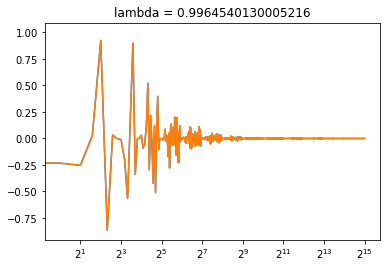

0.9986773254634551


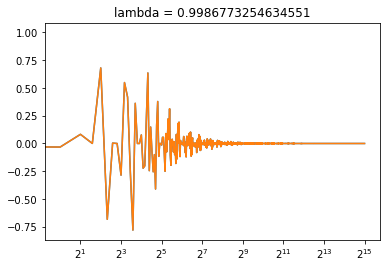

0.9882240023282747


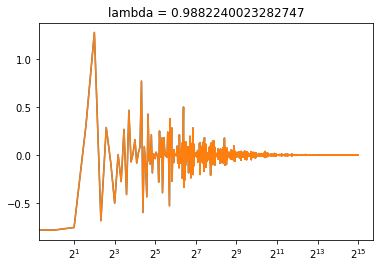

0.999999999999977


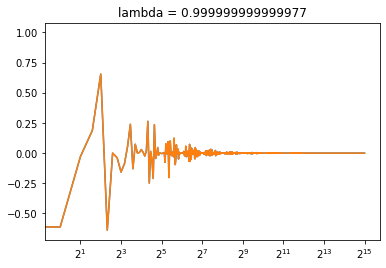

0.9104553690689828


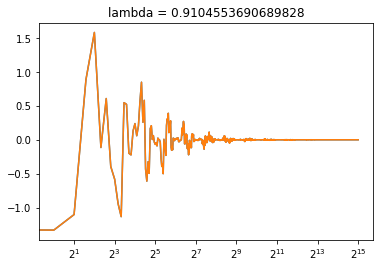

0.9986162834445932


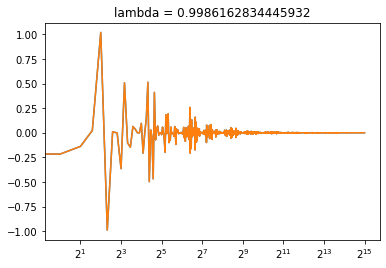

0.9444949065115007


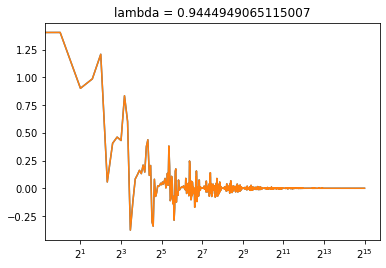

0.9916452552709465


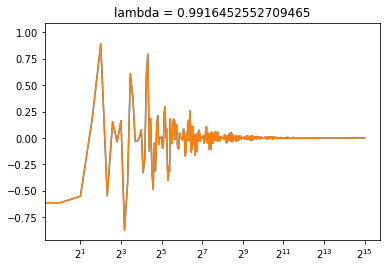

0.9891701130387802


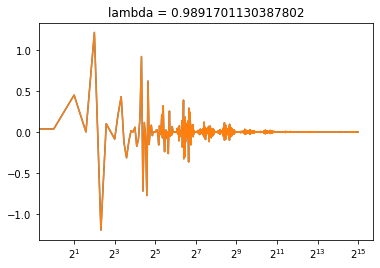

0.9999976605733324


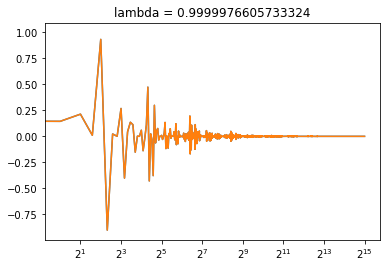

0.999999999999988


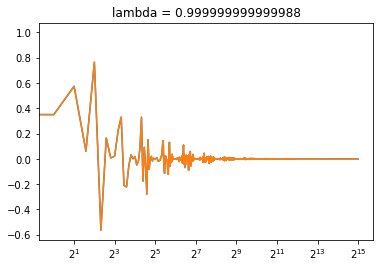

0.9784347688510582


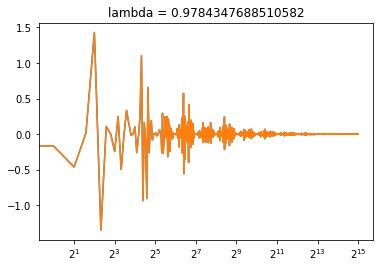

0.9846140730776628


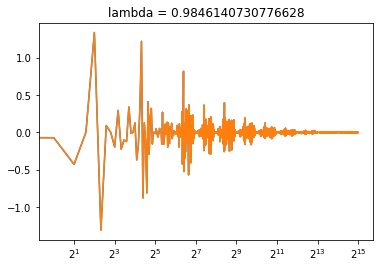

In [98]:
for sample in range(20):
    sig_s = esig.stream2sig(processes_ll[sample, :, :].reshape(30, 2), 14)
    lamb = get_normalize_sig_const(sig_s, 14)
    
    sig_norm = normalize_sig(sig_s, 14)
    sig_unnorm_scaled = esig.stream2sig(lamb*processes_ll[sample, :, :].reshape(30, 2), 14)
    
    plt.figure()
    plt.plot(sig_norm)
    plt.plot(sig_unnorm_scaled)
    plt.title('lambda = {}'.format(lamb))
    plt.xscale('log', base = 2)
    plt.show()

In [110]:
gram_matrix = get_normalized_gram_matrix_for_paths(processes_ll, 14)

In [100]:
lambdas = np.zeros(20)

In [101]:
for sample in range(20):
    sig_s = esig.stream2sig(processes_ll[sample, :, :].reshape(30, 2), 14)
    lamb = get_normalize_sig_const(sig_s, 14)
    
    lambdas[sample] = lamb

In [103]:
import pickle

In [114]:
RESULTS = {
    'processes_lead_lag' : processes_ll,
    'lambdas' : lambdas,
    'gram_matrix' : gram_matrix, 
    'comment' : 'Process indices: Sample, Time, Lead/Lag'
}

In [115]:
with open('pickles/comparison_ds_for_normalized_sig_pde_kernel.pickle', 'wb') as file:
    pickle.dump(RESULTS, file)

In [116]:
RESULTS

{'processes_lead_lag': array([[[ 0.17681574,  0.21490928],
         [ 0.26326288,  0.17681574],
         [ 0.37201756,  0.26326288],
         ...,
         [-0.72741271, -0.66506784],
         [-0.74598178, -0.72741271],
         [-0.79884318, -0.74598178]],
 
        [[ 0.03278709,  0.17039214],
         [-0.13589813,  0.03278709],
         [-0.15025423, -0.13589813],
         ...,
         [ 0.37871911,  0.36744782],
         [ 0.51514197,  0.37871911],
         [ 0.26129079,  0.51514197]],
 
        [[ 0.14949934,  0.28497361],
         [ 0.05479762,  0.14949934],
         [ 0.0508062 ,  0.05479762],
         ...,
         [ 0.15522894, -0.17764543],
         [ 0.25056968,  0.15522894],
         [ 0.49841161,  0.25056968]],
 
        ...,
 
        [[-0.26400018, -0.32961829],
         [ 0.08090615, -0.26400018],
         [-0.1765828 ,  0.08090615],
         ...,
         [-0.05923695, -0.14528276],
         [ 0.24457597, -0.05923695],
         [ 0.08593937,  0.24457597]],
 
       